<a href="https://colab.research.google.com/github/nailamnsr/PROJECT-P-WEB/blob/main/Copie_de_prototypical_networks_pytorch_omniglot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prototypical Netwoks on the Omniglot dataset

You can save a copy to your Drive before executing this notebook



*   `Author:` Cyprien NIELLY
*   `Date:` 05/2020
*   `Credit:` Main source of inspiration [https://github.com/jakesnell/prototypical-networks](https://github.com/jakesnell/prototypical-networks)



##Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
#Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


##Import data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

100%|██████████| 658M/658M [00:06<00:00, 104MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1


In [ ]:
import os
import torch
import shutil
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import random

# 📌 Définition des transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionner les images
    transforms.ToTensor(),  # Convertir en tenseur PyTorch
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalisation
])

# 📌 Définition d'une classe Dataset personnalisée
class PlantVillageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # Liste des classes
        self.data = []

        # Lire les images et associer chaque classe à un label
        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# 📌 1️⃣ Définition des chemins
dataset_path = "PlantVillage"  # Dossier original
train_path = "PlantVillage/train"
test_path = "PlantVillage/test"

# 📌 2️⃣ Sélection des classes
all_classes = os.listdir(dataset_path)
random.shuffle(all_classes)
train_classes = all_classes[:10]
test_classes = all_classes[10:15]

# 📌 3️⃣ Création des dossiers train et test
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

for class_name in train_classes:
    src = os.path.join(dataset_path, class_name)
    dst = os.path.join(train_path, class_name)
    shutil.copytree(src, dst, dirs_exist_ok=True)  # Copie sans supprimer l'original

for class_name in test_classes:
    src = os.path.join(dataset_path, class_name)
    dst = os.path.join(test_path, class_name)
    shutil.copytree(src, dst, dirs_exist_ok=True)

print("✅ Dataset divisé avec succès !")
print("📂 Classes Train :", train_classes)
print("📂 Classes Test :", test_classes)

# 📌 4️⃣ Chargement des datasets
train_dataset = PlantVillageDataset(train_path, transform=transform)
test_dataset = PlantVillageDataset(test_path, transform=transform)

# 📌 5️⃣ Vérifier la structure du dataset
print(f"Nombre total d'images dans TRAIN : {len(train_dataset)}")
print(f"Nombre total d'images dans TEST : {len(test_dataset)}")

# 📌 6️⃣ Afficher un exemple d'image
sample_img, sample_label = train_dataset[0]
print(f"Taille de l'image : {sample_img.shape}, Label : {sample_label}")


✅ Dataset divisé avec succès !
📂 Classes Train : ['Tomato_Bacterial_spot', 'Tomato__Tomato_mosaic_virus', 'Tomato_Late_blight', 'Potato___Early_blight', 'Tomato_Leaf_Mold', 'Tomato_healthy', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Early_blight', 'Potato___Late_blight']
📂 Classes Test : ['Pepper__bell___healthy', 'Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite']
Nombre total d'images dans TRAIN : 14565
Nombre total d'images dans TEST : 6074
Taille de l'image : torch.Size([3, 128, 128]), Label : 0


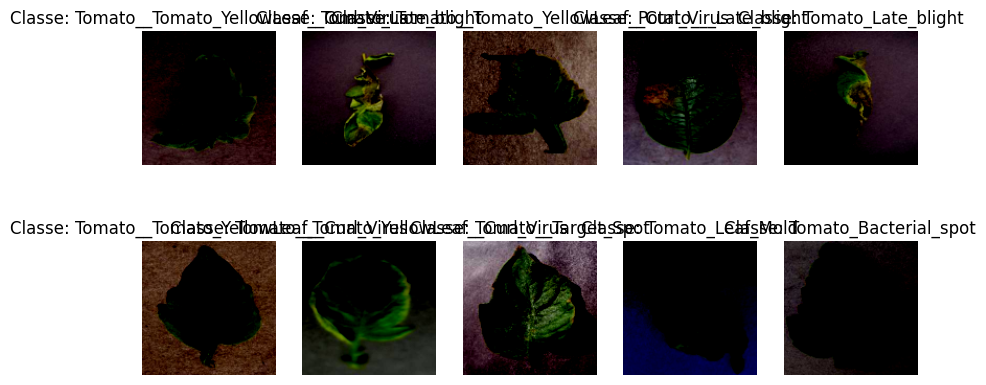

In [ ]:
import matplotlib.pyplot as plt
import random

# Afficher quelques images aléatoires du dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for ax in axes.flat:
    idx = random.randint(0, len(train_dataset) - 1)
    img, label = train_dataset[idx]
    ax.imshow(img.permute(1, 2, 0))  # Convertir le format pour affichage
    ax.set_title(f"Classe: {train_dataset.classes[label]}")
    ax.axis("off")

plt.show()


In [ ]:
import os
print(os.listdir("PlantVillage"))  # Liste les fichiers dans PlantVillage


['Pepper__bell___healthy', 'Tomato__Tomato_mosaic_virus', 'Potato___healthy', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Potato___Late_blight', 'Tomato_Late_blight', 'Pepper__bell___Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Potato___Early_blight', 'Tomato__Target_Spot', 'Tomato_Leaf_Mold', 'Tomato_Bacterial_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


In [ ]:
import os
print(os.listdir("PlantVillage"))  # Affiche le contenu du dossier


['Pepper__bell___healthy', 'Tomato__Tomato_mosaic_virus', 'Potato___healthy', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Potato___Late_blight', 'Tomato_Late_blight', 'Pepper__bell___Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Potato___Early_blight', 'Tomato__Target_Spot', 'Tomato_Leaf_Mold', 'Tomato_Bacterial_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


In [ ]:
import shutil

if "PlantVillage" in os.listdir("PlantVillage"):
    shutil.move("PlantVillage/PlantVillage", "PlantVillage_temp")
    shutil.rmtree("PlantVillage")
    shutil.move("PlantVillage_temp", "PlantVillage")

print("Chemin corrigé :", os.listdir("PlantVillage"))


Chemin corrigé : ['Pepper__bell___healthy', 'Tomato__Tomato_mosaic_virus', 'Potato___healthy', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Potato___Late_blight', 'Tomato_Late_blight', 'Pepper__bell___Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Potato___Early_blight', 'Tomato__Target_Spot', 'Tomato_Leaf_Mold', 'Tomato_Bacterial_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


In [ ]:
import os
print(os.listdir())  # Affiche les fichiers du répertoire actuel


['.config', 'plantdisease.zip', 'PlantVillage', 'sample_data']


In [ ]:
!kaggle datasets download -d emmarex/plantdisease


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 654M/658M [00:02<00:00, 259MB/s]
100% 658M/658M [00:02<00:00, 257MB/s]


In [ ]:
import zipfile

zip_path = "plantdisease.zip"  # Vérifie le nom du fichier ZIP téléchargé
extract_path = "PlantVillage"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction terminée !")
print(os.listdir(extract_path))  # Vérifie le contenu du dossier


Extraction terminée !
['PlantVillage', 'plantvillage']


In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Réduire la taille des images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [ ]:
from torch.utils.data import DataLoader

# Définition des paramètres
batch_size = 32  # On peut ajuster selon la mémoire dispo
shuffle = True  # Mélanger les données pour éviter le sur-apprentissage

# Création du DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Vérification
for images, labels in train_loader:
    print(f"Taille du batch: {images.shape}, Labels: {labels.shape}")
    break  # On affiche juste un batch pour tester


Taille du batch: torch.Size([32, 3, 128, 128]), Labels: torch.Size([32])


##Read data

In [ ]:
from multiprocessing import Pool, cpu_count
def read_class_images(class_directory_path, class_name):
    """
    Lit toutes les images d'une classe (maladie des plantes).
    """
    datax = []
    datay = []

    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif")  # Extensions valides
    images = os.listdir(class_directory_path)

    for img in images:
        img_path = os.path.join(class_directory_path, img)

        # Vérifier si le fichier a une extension valide
        if not img.lower().endswith(valid_extensions):
            print(f"⚠️ Fichier ignoré : {img_path}")
            continue

        try:
            # Ouvrir l'image avec PIL et appliquer les transformations
            image = Image.open(img_path).convert("RGB")
            image = transform(image)  # Appliquer les transformations

            datax.append(image)
            datay.append(class_name)  # On garde le nom de la classe comme label

        except Exception as e:
            print(f"❌ Erreur lors de la lecture de {img_path}: {e}")

    return datax, datay




In [ ]:
def read_images(base_directory):
    """
    Lit toutes les classes depuis PlantVillage en utilisant du multiprocessing.
    """
    datax = []
    datay = []

    classes = os.listdir(base_directory)
    pool = Pool(cpu_count())

    results = pool.starmap(read_class_images, [(os.path.join(base_directory, class_name), class_name) for class_name in classes])

    pool.close()
    pool.join()

    for result in results:
        datax.extend(result[0])
        datay.extend(result[1])

    return np.array(datax), np.array(datay)

The Omniglot dataset contains 1,623 different handwritten characters from 50 different alphabets. Each of the 1623 characters was drawn online via Amazon's Mechanical Turk by 20 different people (so 20 examples per character).
It is split into a background set of 30 alphabets and an evaluation set of 20 alphabets. We will use the background set for training and the evaluation set for testing.

In [ ]:
import os

# Vérifie ce qu'il y a dans le dossier principal
print("Contenu de PlantVillage :", os.listdir("PlantVillage"))

# Vérifie le contenu d'un des sous-dossiers (remplace par un vrai nom si besoin)
first_class = os.listdir("PlantVillage")[0]  # Prend le premier dossier
print(f"Contenu de PlantVillage/{first_class} :", os.listdir(f"PlantVillage/{first_class}"))


Contenu de PlantVillage : ['train', 'Pepper__bell___healthy', 'Tomato__Tomato_mosaic_virus', 'Potato___healthy', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Potato___Late_blight', 'Tomato_Late_blight', 'Pepper__bell___Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'test', 'Potato___Early_blight', 'Tomato__Target_Spot', 'Tomato_Leaf_Mold', 'Tomato_Bacterial_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus']
Contenu de PlantVillage/train : ['Tomato__Tomato_mosaic_virus', 'Tomato_healthy', 'Potato___Late_blight', 'Tomato_Late_blight', 'Tomato_Early_blight', 'Potato___Early_blight', 'Tomato__Target_Spot', 'Tomato_Leaf_Mold', 'Tomato_Bacterial_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


In [ ]:
train_path = "PlantVillage/train"
test_path = "PlantVillage/test"

trainx, trainy = read_images(train_path)
testx, testy = read_images(test_path)

# 📌 Vérification
print(f"✅ trainx shape: {trainx.shape}, trainy shape: {trainy.shape}")
print(f"✅ testx shape: {testx.shape}, testy shape: {testy.shape}")

⚠️ Fichier ignoré : PlantVillage/train/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c
✅ trainx shape: (14564, 3, 64, 64), trainy shape: (14564,)
✅ testx shape: (6074, 3, 64, 64), testy shape: (6074,)


##Create samples

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

def extract_sample(n_way, n_support, n_query, datax, datay):
    """
    Sélectionne un échantillon de taille (n_way, n_support + n_query) pour chaque classe.

    Args:
        n_way (int): Nombre de classes à sélectionner
        n_support (int): Nombre d'exemples par classe pour l'ensemble support
        n_query (int): Nombre d'exemples par classe pour l'ensemble query
        datax (np.array): Tableau numpy des images sous forme (N, C, H, W)
        datay (np.array): Tableau numpy des labels associés (N,)

    Returns:
        dict:
            - images (torch.Tensor): Tensor (n_way, n_support+n_query, C, H, W)
            - n_way, n_support, n_query (int)
    """
    datax = np.array(datax)  # S'assurer que c'est un np.array
    datay = np.array(datay)

    sample = []
    classes = np.unique(datay)  # Obtenir les classes uniques

    # Sélectionner n_way classes aléatoires
    chosen_classes = np.random.choice(classes, n_way, replace=False)

    for cls in chosen_classes:
        # Indices des images correspondant à la classe
        class_indices = np.where(datay == cls)[0]

        # Sélectionner les images correspondantes
        datax_cls = datax[class_indices]

        # Mélanger les images pour éviter un biais
        perm = np.random.permutation(len(datax_cls))

        # Prendre n_support + n_query images
        sample_cls = datax_cls[perm[:(n_support + n_query)]]

        sample.append(sample_cls)

    # Convertir en numpy array
    sample = np.array(sample)  # Shape: (n_way, n_support+n_query, C, H, W)

    # Conversion en tensor PyTorch
    sample = torch.from_numpy(sample).float()

    return {
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query
    }

In [ ]:
def display_sample(sample):
    """
    Affiche un échantillon sous forme de grille.

    Args:
        sample (torch.Tensor): Échantillon d'images à afficher
    """
    # Convertir en 4D (batch, C, H, W) pour `make_grid`
    sample_4D = sample.view(sample.shape[0] * sample.shape[1], *sample.shape[2:])

    # Créer une grille d'images
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])

    # Affichage
    plt.figure(figsize=(16, 7))
    plt.imshow(out.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


As an example, let's pick a sample and display it

*   n_way = 8
*   n_support = 5
*   n_query = 5




In [ ]:
batch = extract_sample(n_way=3, n_support=3, n_query=3, datax=trainx, datay=trainy)


print(batch['images'].shape)

torch.Size([3, 6, 3, 64, 64])


In [ ]:
sample_example['images'].shape

NameError: name 'sample_example' is not defined

##Build model

Paper: [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

The embedding part takes a (28x28x3) image and returns a column vector of length 64. The image2vector function is composed of 4 modules. Each module comprises a 64-filter 3 × 3 convolution, a batch normalization layer, a ReLU nonlinearity and a 2 × 2 max-pooling layer.

When applied to the 28 × 28 Omniglot images this architecture results in a 64-dimensional output space.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

def load_protonet_conv(**kwargs):
    """
    Charge le modèle Prototypical Network avec ResNet comme encodeur.
    Args:
        x_dim (tuple): dimensions des images (par défaut (3, 128, 128))
    Returns:
        ProtoNet: modèle Prototypical Network
    """
    # Charger ResNet pré-entraîné
    encoder = models.resnet18(pretrained=True)  # Remplace par resnet34, resnet50 si besoin
    encoder.fc = nn.Identity()  # Supprime la dernière couche de classification

    return ProtoNet(encoder)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ProtoNet(nn.Module):
    def __init__(self, encoder):
        """
        Args:
            encoder : CNN encodant les images du dataset
        """
        super(ProtoNet, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder = encoder.to(self.device)

    def forward(self, x):
        """Encode directement les images avec le CNN"""
        return self.encoder(x.to(self.device))

    def set_forward_loss(self, sample):
        """
        Calcule la perte et l'accuracy du modèle.
        Args:
            sample (dict): contient 'images' (Tensor), n_way, n_support, n_query
        Returns:
            loss, {'loss': loss, 'acc': accuracy, 'y_hat': predictions}
        """
        sample_images = sample['images'].to(self.device)
        n_way, n_support, n_query = sample['n_way'], sample['n_support'], sample['n_query']

        # Séparer support et query
        x_support = sample_images[:, :n_support]  # (n_way, n_support, C, H, W)
        x_query = sample_images[:, n_support:]    # (n_way, n_query, C, H, W)

        # Indices cibles
        target_inds = torch.arange(n_way).view(n_way, 1).expand(n_way, n_query).to(self.device)

        # Encoder les images (support + query)
        x = torch.cat([x_support.reshape(n_way * n_support, *x_support.shape[2:]),
                       x_query.reshape(n_way * n_query, *x_query.shape[2:])], dim=0)
        z = self.encoder(x)

        # Définir les prototypes
        z_dim = z.size(-1)  # Taille de l'espace de sortie
        z_proto = z[:n_way * n_support].view(n_way, n_support, z_dim).mean(dim=1)  # (n_way, z_dim)
        z_query = z[n_way * n_support:]  # (n_way * n_query, z_dim)

        # Calcul des distances euclidiennes
        dists = euclidean_dist(z_query, z_proto)  # (n_way * n_query, n_way)

        # Probabilités
        log_p_y = F.log_softmax(dists, dim=1).view(n_way, n_query, -1)


        # Calcul de la loss
        loss_val = -log_p_y.gather(2, target_inds.unsqueeze(-1)).squeeze().mean()

        # Prédictions et accuracy
        _, y_hat = log_p_y.max(2)
        acc_val = torch.eq(y_hat, target_inds).float().mean()

        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': y_hat
        }

In [ ]:
def euclidean_dist(x, y):
    """
    Calcule la distance euclidienne entre x et y.
    Args:
        x (torch.Tensor): shape (n, d) - n = n_way * n_query
        y (torch.Tensor): shape (m, d) - m = n_way
    Returns:
        torch.Tensor: shape(n, m) - distances de chaque query à chaque prototype
    """
    n, d = x.shape
    m, _ = y.shape
    assert d == y.shape[1]

    # Expand dimensions pour le broadcast
    x = x.unsqueeze(1).expand(n, m, d)  # (n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)  # (n, m, d)

    return torch.pow(x - y, 2).sum(dim=2)  # (n,

##Train

In [ ]:
from tqdm import tqdm
import torch.optim as optim

In [ ]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    """
    Entraîne le Prototypical Network.
    Args:
        model : modèle ProtoNet
        optimizer : optimiseur (Adam, SGD, etc.)
        train_x (np.array) : images du dataset d'entraînement
        train_y (np.array) : labels du dataset d'entraînement
        n_way (int) : nombre de classes par tâche
        n_support (int) : nombre d'exemples de support par classe
        n_query (int) : nombre d'exemples de query par classe
        max_epoch (int) : nombre d'époques
        epoch_size (int) : nombre d'épisodes par époque
    """
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)


    epoch = 0

    while epoch < max_epoch:
        running_loss = 0.0
        running_acc = 0.0

        for _ in tqdm(range(epoch_size), desc=f"Époch {epoch+1}/{max_epoch}"):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size
        print(f"Époch {epoch+1} -- Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        epoch += 1
        scheduler.step()

In [ ]:
%%time

model = load_protonet_conv(
    x_dim=(3, 64, 64),  # Taille des images 64x64x3
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Ajuste n_way selon le nombre de classes
n_way = 10
n_support = 20
n_query = 20

max_epoch =5
epoch_size = 500  # Réduire si RAM insuffisante

train(model, optimizer, trainx, trainy, n_way, n_support, n_query, max_epoch, epoch_size)

Époch 1/5: 100%|██████████| 500/500 [04:26<00:00,  1.87it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Époch 1 -- Loss: 8.5503 Acc: 0.0616


Époch 2/5:  92%|█████████▏| 460/500 [04:04<00:21,  1.88it/s]


KeyboardInterrupt: 

##Test

In [ ]:
from tqdm import tnrange
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  running_loss = 0.0
  running_acc = 0.0
  for episode in tnrange(test_episode):
    sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
    loss, output = model.set_forward_loss(sample)
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [ ]:
n_way = 5
n_support = 20
n_query = 10

test_x = testx
test_y = testy

test_episode = 1000

test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

<ipython-input-59-e1506df7f7c6>:16: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(test_episode):


  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 1.4502 Acc: 0.6080


##Test on specific example

Let's test the model on a specific example to visualize how well does it label the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


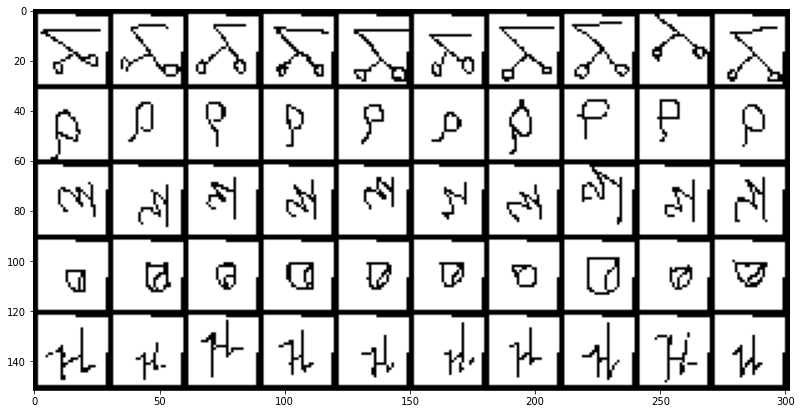

In [ ]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

In [ ]:
my_loss, my_output = model.set_forward_loss(my_sample)

In [ ]:
my_output

{'acc': 1.0, 'loss': 1.0681152389224735e-06, 'y_hat': tensor([[0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4]], device='cuda:0')}

In [5]:
!echo "# prototypical-networks-for-few-shot-learning" >> README.md
!git init
!git add README.md
!git commit -m "first commit"
!git branch -M main
!git remote add origin https://github.com/nailamnsr/prototypical-networks-for-few-shot-learning.git
!git push -u origin main

Reinitialized existing Git repository in /content/.git/
[main e1dee6f] first commit
 1 file changed, 1 insertion(+)
error: remote origin already exists.
fatal: could not read Username for 'https://github.com': No such device or address


In [4]:
!git config --global user.name "nailamnsr"
!git config --global user.email "mansournaila0@gmail.com"


In [6]:
!git remote -v


origin	https://github.com/nailamnsr/prototypical-networks-for-few-shot-learning.git (fetch)
origin	https://github.com/nailamnsr/prototypical-networks-for-few-shot-learning.git (push)
